
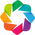

In [20]:
import pandas as pd
import datetime
import ccxt
import time
import numpy as np
import sqlite3
import pandas.io.sql as psql
import matplotlib.pyplot as plt
import holoviews as hv
import warnings
warnings.filterwarnings("ignore")
from holoviews.operation.timeseries import rolling, rolling_outlier_std
from holoviews.streams import Stream
hv.notebook_extension('bokeh')
import matplotlib.ticker as mticker
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller, coint, grangercausalitytests

## Checando as moedas disponíveis na Poloniex

Único momento do código que usamos a CCXT

In [113]:
exchange = ccxt.poloniex()
markets = exchange.load_markets()
print("Contém {} moedas".format(len(markets.keys())))
markets.keys()

Contém 99 moedas


dict_keys(['BCN/BTC', 'BELA/BTC', 'BLK/BTC', 'BTCD/BTC', 'Bitmark/BTC', 'BTS/BTC', 'BURST/BTC', 'CLAM/BTC', 'DASH/BTC', 'DGB/BTC', 'DOGE/BTC', 'EMC2/BTC', 'FLDC/BTC', 'FLO/BTC', 'GAME/BTC', 'GRC/BTC', 'HUC/BTC', 'LTC/BTC', 'MAID/BTC', 'OMNI/BTC', 'NAV/BTC', 'NEOS/BTC', 'NMC/BTC', 'NXT/BTC', 'PINK/BTC', 'POT/BTC', 'PPC/BTC', 'RIC/BTC', 'XLM/BTC', 'SYS/BTC', 'VIA/BTC', 'XVC/BTC', 'VRC/BTC', 'VTC/BTC', 'XBC/BTC', 'XCP/BTC', 'XEM/BTC', 'XMR/BTC', 'XPM/BTC', 'XRP/BTC', 'BTC/USDT', 'DASH/USDT', 'LTC/USDT', 'NXT/USDT', 'XLM/USDT', 'XMR/USDT', 'XRP/USDT', 'BCN/XMR', 'BLK/XMR', 'BTCD/XMR', 'DASH/XMR', 'LTC/XMR', 'MAID/XMR', 'NXT/XMR', 'ETH/BTC', 'ETH/USDT', 'SC/BTC', 'BCY/BTC', 'EXP/BTC', 'FCT/BTC', 'RADS/BTC', 'AMP/BTC', 'DCR/BTC', 'LSK/BTC', 'LSK/ETH', 'LBC/BTC', 'STEEM/BTC', 'STEEM/ETH', 'SBD/BTC', 'ETC/BTC', 'ETC/ETH', 'ETC/USDT', 'REP/BTC', 'REP/USDT', 'REP/ETH', 'ARDR/BTC', 'ZEC/BTC', 'ZEC/ETH', 'ZEC/USDT', 'ZEC/XMR', 'STRAT/BTC', 'NXC/BTC', 'PASC/BTC', 'GNT/BTC', 'GNT/ETH', 'GNO/BTC', 'G

## Criando a função que extrai os dados da Poloniex

Serão criadas 2 funções para captar dados, uma para cada frequência dos dados (diário e em 5 minutos)

Os argumentos da função são:

Pair = O pair no formato da lista disponibilizada pela ccxt (A url da Poloniex pede o pair em outro formato, por isso tratei a string)

Datas (data_inicial e data_final) = As datas devem estar em formato "%d/%m/%Y"

In [ ]:
def captar_dados(pair,data_inicial, data_final):
    pair_modificado = pair.split('/')
    pair_modificado2 = pair_modificado[1]+"_"+pair_modificado[0]
    data_inicial_timestamp = time.mktime(datetime.datetime.strptime(data_inicial, "%d/%m/%Y").timetuple())
    data_final_timestamp = time.mktime(datetime.datetime.strptime(data_final, "%d/%m/%Y").timetuple())
    url = (('https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period=300').
           format(pair_modificado2,int(data_inicial_timestamp),int(data_final_timestamp)))
    df = pd.read_json(url)     
    return(df)

In [114]:
def captar_dados_diario(pair,data_inicial, data_final):
    pair_modificado = pair.split('/')
    pair_modificado2 = pair_modificado[1]+"_"+pair_modificado[0]
    data_inicial_timestamp = time.mktime(datetime.datetime.strptime(data_inicial, "%d/%m/%Y").timetuple())
    data_final_timestamp = time.mktime(datetime.datetime.strptime(data_final, "%d/%m/%Y").timetuple())
    url = (('https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period=86400').
           format(pair_modificado2,int(data_inicial_timestamp),int(data_final_timestamp)))
    df = pd.read_json(url)     
    return(df)

## Criação do dataframe com frequência diária

Nele inclui todas as moedas disponíveis. 01/01/2017 até 31/12/2017

Não foi possível obter observações de Bitmark/BTC, XLM/BTC, XLM/USDT.

In [247]:
t0 = time.time()
crypto_currencies = list(markets.keys())
data_final_diario = pd.DataFrame()
for i in range(0,len(crypto_currencies)):
    try:
        x = captar_dados_diario(pair=crypto_currencies[i],data_inicial='01/01/2017', data_final='31/12/2017')            
    except ValueError:
        print('cannot open', crypto_currencies[i])
        x = pd.DataFrame()
    x['Pair'] = crypto_currencies[i]
    data_final_diario = data_final_diario.append(x)
    
# Contagem do tempo

y1 = int((time.time() - t0)/60)
y2 = int((time.time() - t0)%60)
print("A execução dessa linha demorou {} minutos e {} segundos".format(y1,y2))

cannot open Bitmark/BTC
cannot open XLM/BTC
cannot open XLM/USDT
A execução dessa linha demorou 1 minutos e 19 segundos


## Criação do dataframe com frequência maior

Nele inclui todas as moedas disponíveis. A frequência dos dados é de 5 minutos e vai do primeiro ao último dia de 2017.

Não foi possível obter observações de Bitmark/BTC, XLM/BTC, XLM/USDT.

In [ ]:
t0 = time.time()
crypto_currencies = list(markets.keys())
data_final = pd.DataFrame()
for i in range(0,len(crypto_currencies)):
    try:
        x = captar_dados(pair=crypto_currencies[i],data_inicial='01/01/2017', data_final='31/12/2017')            
    except ValueError:
        print('cannot open', crypto_currencies[i])
        x = pd.DataFrame()
    x['Pair'] = crypto_currencies[i]
    data_final = data_final.append(x)
    
# Contagem do tempo

y1 = int((time.time() - t0)/60)
y2 = int((time.time() - t0)%60)
print("A execução dessa linha demorou {} minutos e {} segundos".format(y1,y2))

## Reorganizando as colunas (Para ambos dataframes)

In [ ]:
cols_1 = ['date','Pair',
 'close',
 'high',
 'low',
 'open',
 'quoteVolume',
 'volume',
 'weightedAverage']
data_final = data_final[cols_1]

In [248]:
cols_1 = ['date','Pair','open',
 'close',
 'high',
 'low',
  'quoteVolume',
 'volume',
 'weightedAverage']
data_final_diario = data_final_diario[cols_1]

## Criando o banco de dados SQL

In [249]:
conn = sqlite3.connect('crypto_pedro.db')
cursor = conn.cursor()

In [ ]:
data_final.to_sql("data_final", conn,index=False, if_exists="replace")

In [250]:
data_final_diario.to_sql("data_final_diario", conn,index=False, if_exists="replace")

## Extraindo dados o dataframe no SQL

Agora, ao invés de coletar as 96 moedas, vou trabalhar com 3 moedas para a visualização gráfica.

ETH
DOGE
LTC

In [2]:
conn = sqlite3.connect('crypto_pedro.db')

In [3]:
data_graph = pd.DataFrame()    
for i in ['ETH/BTC', 'DOGE/BTC', 'LTC/BTC']:
    x = pd.read_sql_query(("SELECT date, Pair, close, open, high, low FROM data_final WHERE Pair LIKE '{}';").format(i), conn)
    data_graph = data_graph.append(x)

In [4]:
data_graph_diario = pd.DataFrame()    
for i in ['ETH/BTC', 'DOGE/BTC', 'LTC/BTC']:
    x = pd.read_sql_query(("SELECT date, Pair, open, high, low, close FROM data_final_diario WHERE Pair LIKE '{}';").format(i), conn)
    data_graph_diario = data_graph_diario.append(x)

In [5]:
ether = data_graph[(data_graph.Pair == "ETH/BTC")]
doge = data_graph[(data_graph.Pair == "DOGE/BTC")]
ltc = data_graph[(data_graph.Pair == "LTC/BTC")]

In [6]:
ether_diario = data_graph_diario[(data_graph_diario.Pair == "ETH/BTC")]
doge_diario = data_graph_diario[(data_graph_diario.Pair == "DOGE/BTC")]
ltc_diario = data_graph_diario[(data_graph_diario.Pair == "LTC/BTC")]

# Visualização Gráfica

## Candlestick em frequência diária - ETH

In [12]:
ether_candle = ether_diario.drop('Pair', 1)

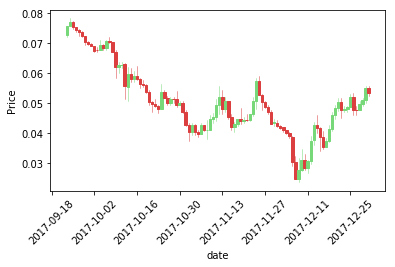

In [30]:
df_ohlc = ether_candle[-100:]

df_ohlc.columns = ["date","open","high",'low', "close"]

df_ohlc["date"] = pd.to_datetime(df_ohlc["date"])
df_ohlc['date'] = df_ohlc['date'].map(mdates.date2num)

fig = plt.figure()
ax1 = plt.subplot2grid((12,1), (0,0), rowspan=10, colspan=1)

ax1.xaxis_date()
plt.xlabel("date")

candlestick_ohlc(ax1,df_ohlc.values,width=0.8, colorup='#77d879', colordown='#db3f3f')
plt.ylabel("Price")
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(45)

plt.show()


## Gráfico de correlação

In [31]:
def load_symbol(symbol, **kwargs):
    df = data[symbol]
    #df.reset_index(level=0, inplace=True)
    df['date'] = df.index
    return hv.Curve(df, ('date', 'Date'), ('close', 'Close price'))

stock_symbols = ['ETH', 'LTC', 'DOGE']
data = {"ETH": ether, 'LTC':ltc,'DOGE':doge }
dmap = hv.DynamicMap(load_symbol, kdims='Symbol').redim.values(Symbol=stock_symbols)

In [18]:
%%opts Curve [width=700, height=500, show_grid=True] {+framewise}
def rolling_corr(w, **kwargs):
    S = ether['close'].rolling(w).corr(other=ltc['close'])
    ether['corrLTC'] = S
    

    return hv.Curve(ether.iloc[-1000:], ('date', 'Date'), ('corrLTC','Rolling correlation'))

#smoothed = dmap*rolling(dmap, rolling_window=30)*rolling_outlier_std(dmap)
winsize = {s:rolling_corr(s) for s in range(10,60,2)}
rcorr = hv.HoloMap(winsize, kdims='Window size')
rcorr

:HoloMap   [Window size]
   :Curve   [date]   (corrLTC)

## Gráfico dos Retornos, Gráfico de Dispersão e Teste de Cointegração 

In [22]:
ether['retorno_eth'] = ether.close/ether.close.shift(1) - 1
ltc['retorno_ltc'] = ltc.close/ltc.close.shift(1) - 1

In [23]:
%%opts Curve [width=700, height=500, show_grid=True] {+framewise}
hv.Curve(ether[-10000:], ('date', 'Date'),('retorno_eth', '5m Return rate'), label='Ether returns').hist(num_bins=150)

:AdjointLayout
   :Curve   [date]   (retorno_eth)
   :Histogram   [retorno_eth]   (retorno_eth_frequency)

In [24]:
results3 = coint(ether['retorno_eth'][-5000:],ltc.close[-5000:])
print('Coint t: {}\np-value: {}'.format(results3[0],results3[1]))
for key,value in zip(['1%','5%', '10%'],results3[2]):
    print('\t%s: %.3f' % (key, value))

Coint t: -12.750262978697105
p-value: 9.124846208747496e-23
	1%: -3.899
	5%: -3.337
	10%: -3.045


In [198]:
%%opts Scatter [width=700, height=500, show_grid=True] {+framewise}
s = hv.Scatter((ether.close[-1000:],ltc.close[-1000:]),kdims=['ETH'], vdims=['LTC'])#.redim.range(ETH=(-.1,.1),BTC=(-.1,.1))
s

:Scatter   [ETH]   (LTC)

## Teste de Estacionariedade

In [199]:
result = adfuller(ether['retorno_eth'][-5000:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.797579
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [25]:
result = adfuller(ltc['retorno_ltc'][-5000:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -37.091933
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [36]:
%%opts Curve [width=700, height=500, show_grid=True] {+framewise}
def rolling_ADF(w, **kwargs):
    S = ether.iloc[-100:].retorno_eth.rolling(w).apply(lambda x: adfuller(x)[1])
    ether['rollingADF'] = S
    

    return hv.Curve(ether.retorno_eth.iloc[-100:], ('date', 'Date'), ('rollingADF','Rolling ADF test p-value'))
    
winsize = {s:rolling_ADF(s) for s in range(30,60,2)}
rcorr = hv.HoloMap(winsize, kdims='Window size')
rcorr

:HoloMap   [Window size]
   :Curve   [date]   (rollingADF)

###### 